In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.spatial import distance
from tqdm import tqdm

# Экспоненциальное распределение
def generate_exponential_samples(n, lambda_param):
    samples = np.random.exponential(1/lambda_param, n)
    return samples

# Гамма распределение
def generate_gamma_samples(n, lambda_param):
    alpha = 1 / 2
    samples = np.random.gamma(alpha, 1 / lambda_param, n)
    return samples

#Генерация Normal(0,σ);
def generate_normal_samles(size, loc=0, scale=1):
    return np.random.normal(loc, scale, size)

#Генерация Student-t(ν)
def generate_standard_t_samles(size, df=3):
    return np.random.standard_t(df, size)

# Построение knn-графа
def generate_knn_digraph(sample, k):
    G = nx.DiGraph()
    sample = np.asarray(sample)
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)

    n_samples = len(sample)
    if k >= n_samples - 1:
        G.add_nodes_from(range(n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    G.add_edge(i, j)
        return G
    G.add_nodes_from(range(n_samples))
    dist_matrix = distance.squareform(distance.pdist(sample))
    for i in range(n_samples):
      neighbors = np.argsort(dist_matrix[i])[1:k+1]
      for neighbor in neighbors:
        G.add_edge(i, neighbor)
    return G

# Построение дистанционного графа
def generate_distance_graph(sample, d):
    G = nx.Graph()

    for i in range(len(sample)):
        G.add_node(i, pos=(sample[i], 0))

    for i in range(len(sample)):
        for j in range(i + 1, len(sample)):
            if abs(sample[i] - sample[j]) <= d:
                G.add_edge(i, j)
    '''
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.title(f'Distance Graph with d = {d}')
    plt.xlabel('Sample Values')
    plt.yticks([])
    plt.show()
    '''
    return G

# макс степень вершины
def max_node_degree(graph):
    if not graph:
        return 0

    degrees = dict(graph.degree())
    max_degree = max(degrees.values())
    return max_degree

# макс. независимое множество UML-диаграмма реализованных классо UML-диаграмма реализованных классо
def max_independent_set_size(graph):
    if not graph:
        return 0
    independent_set = nx.algorithms.approximation.maximum_independent_set(graph)
    return len(independent_set)

#δ(G) - минимальная степень
def min_node_degree(graph):
    if not graph:
        return 0
    degrees = dict(graph.in_degree())
    return min(degrees.values())

#χ(G) - Хроматическое число
def chromatic_number(graph):
    if not graph:
        return 0
    coloring = nx.algorithms.coloring.greedy_color(graph, strategy='largest_first', interchange=True)
    return max(coloring.values()) + 1

**Исследование того, как ведет себя числовая характеристика T в зависимости
от параметров распределений θ и υ  и параметр процедуры построения графа, при вексированном размере выборки.**

Эксперементы с графом knn и нормальным распределением.

Processing k_neighbors: 100%|██████████| 6/6 [06:27<00:00, 64.52s/it]


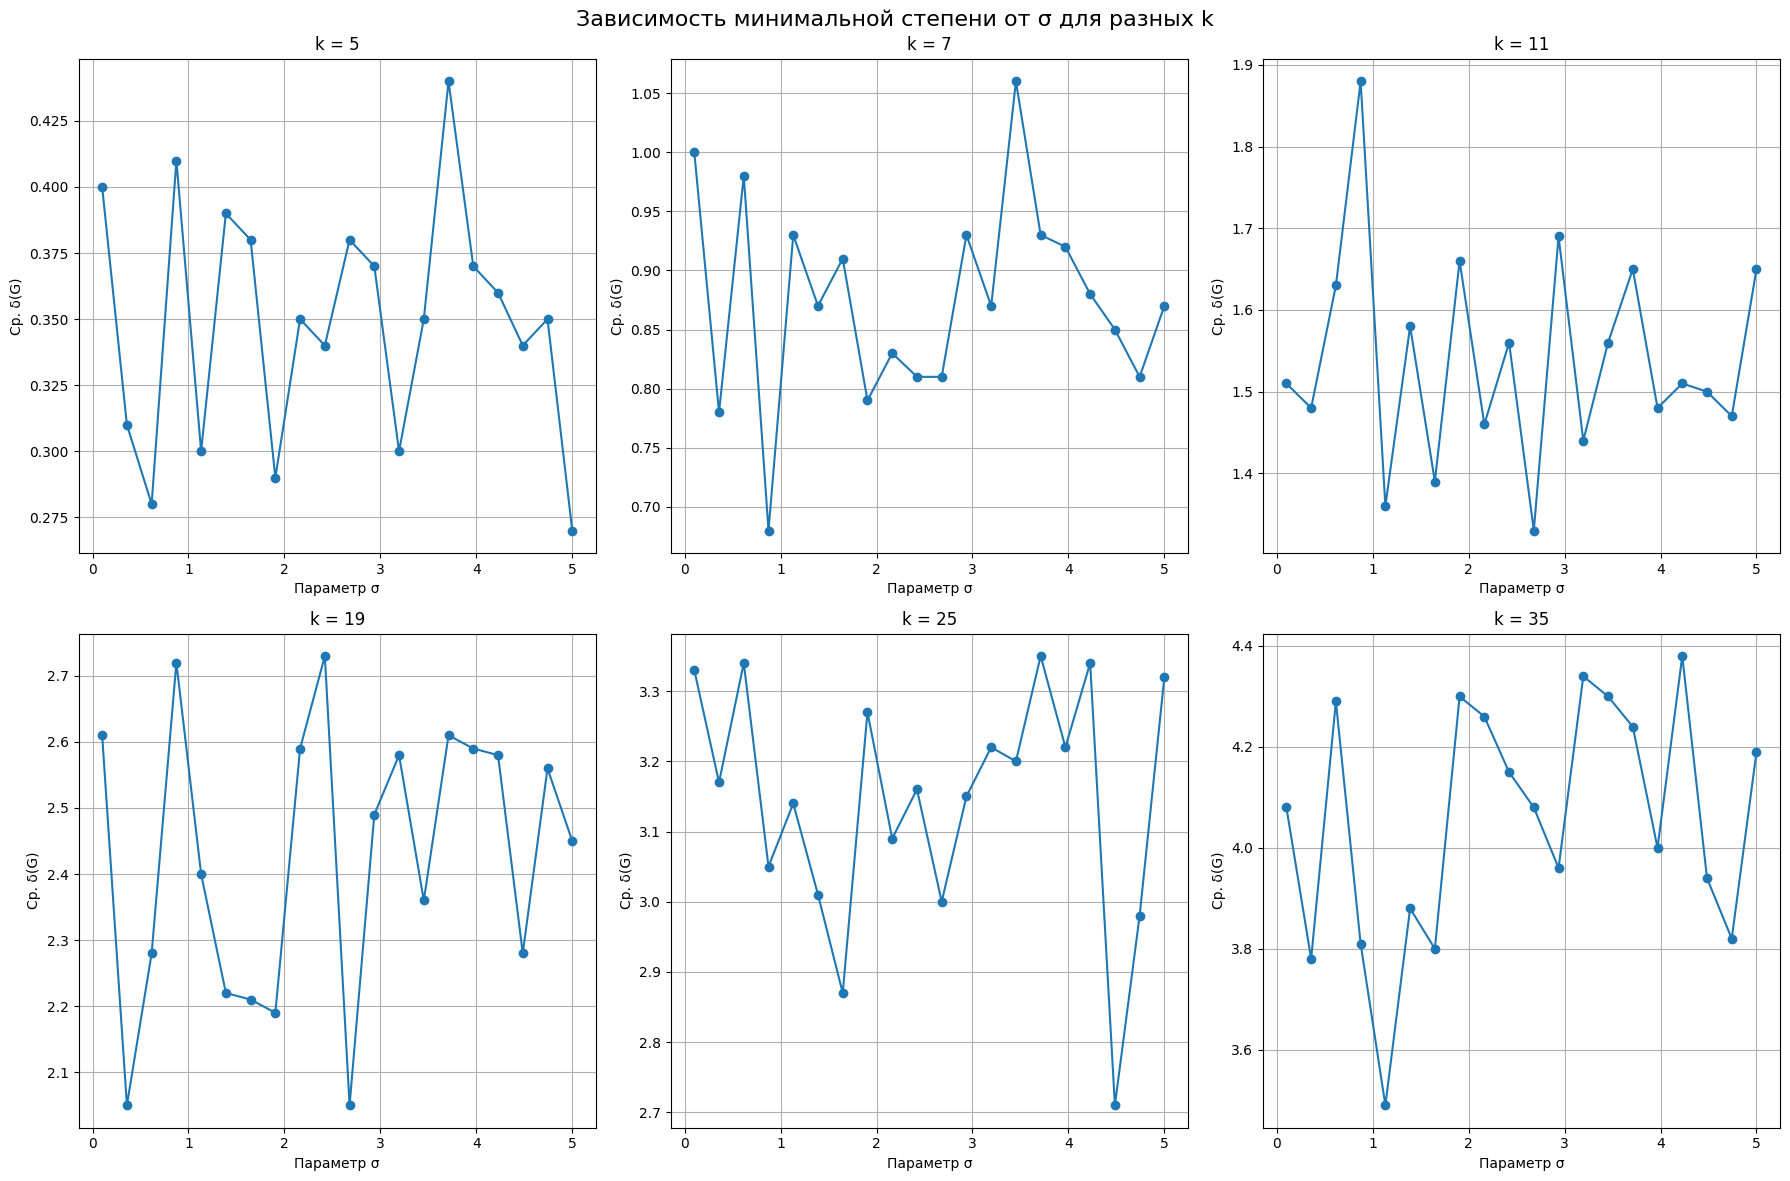

In [ ]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'scale': np.linspace(0.1, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от σ для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for scale in param_grid['scale']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n,scale=scale)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['scale'], min_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. δ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()






Эксперементы с графом knn и Student-t(ν).

Processing k_neighbors: 100%|██████████| 6/6 [06:32<00:00, 65.37s/it]


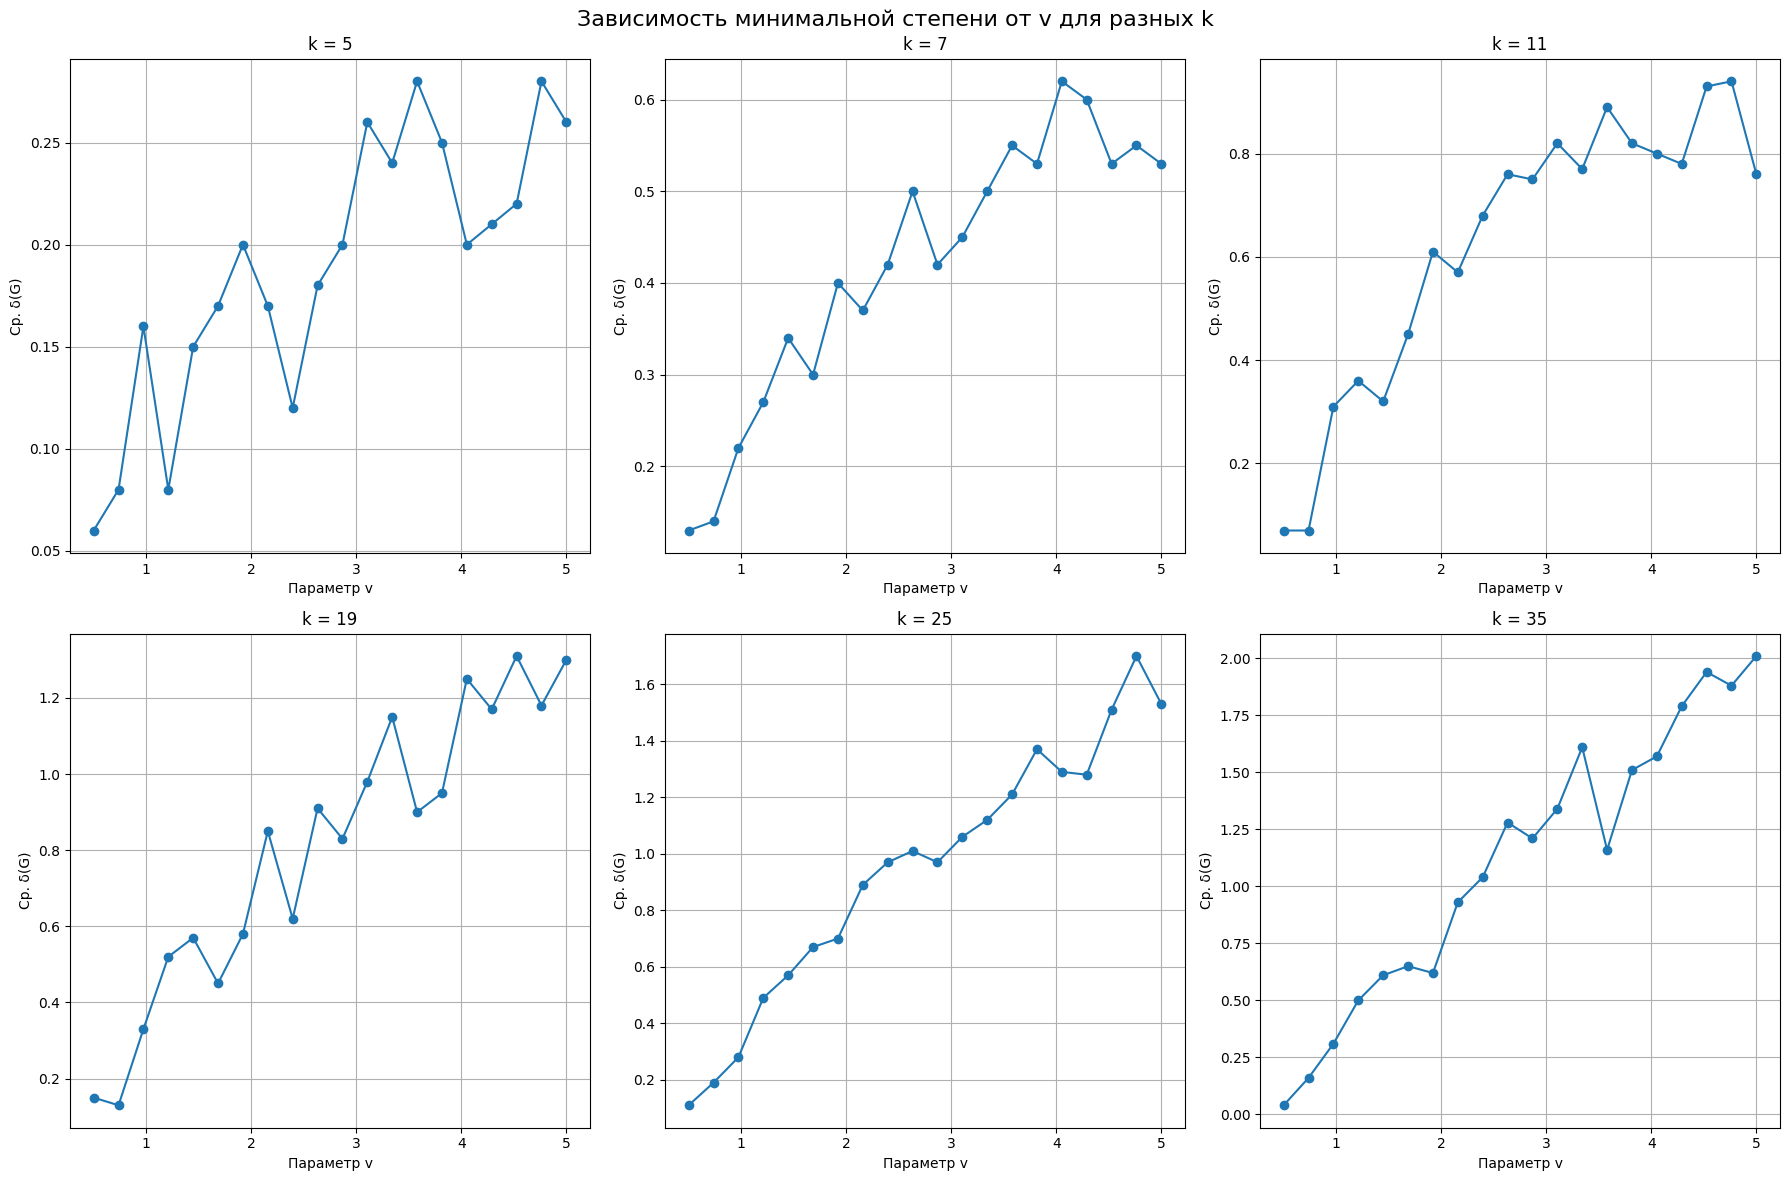

In [ ]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'df': np.linspace(0.5, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от v для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for v in param_grid['df']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n,df=v)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['df'], min_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. δ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()

Мы получили интересный результат. График для нормального распределения выглядит хоотичнее, чем график для Student-t(ν), в графике Student-t(ν) прослеживается рост матожидания минимальной входящей степени вершины, с ростом параметра v. И еще одно интересное наблюдение: для интересующих нас параметром распределений $v_0$ и $\sigma_0$ график распределения Student-t(ν) ниже графика нормального распределения.

Эксперементы с графом dist и нормальным распределением.

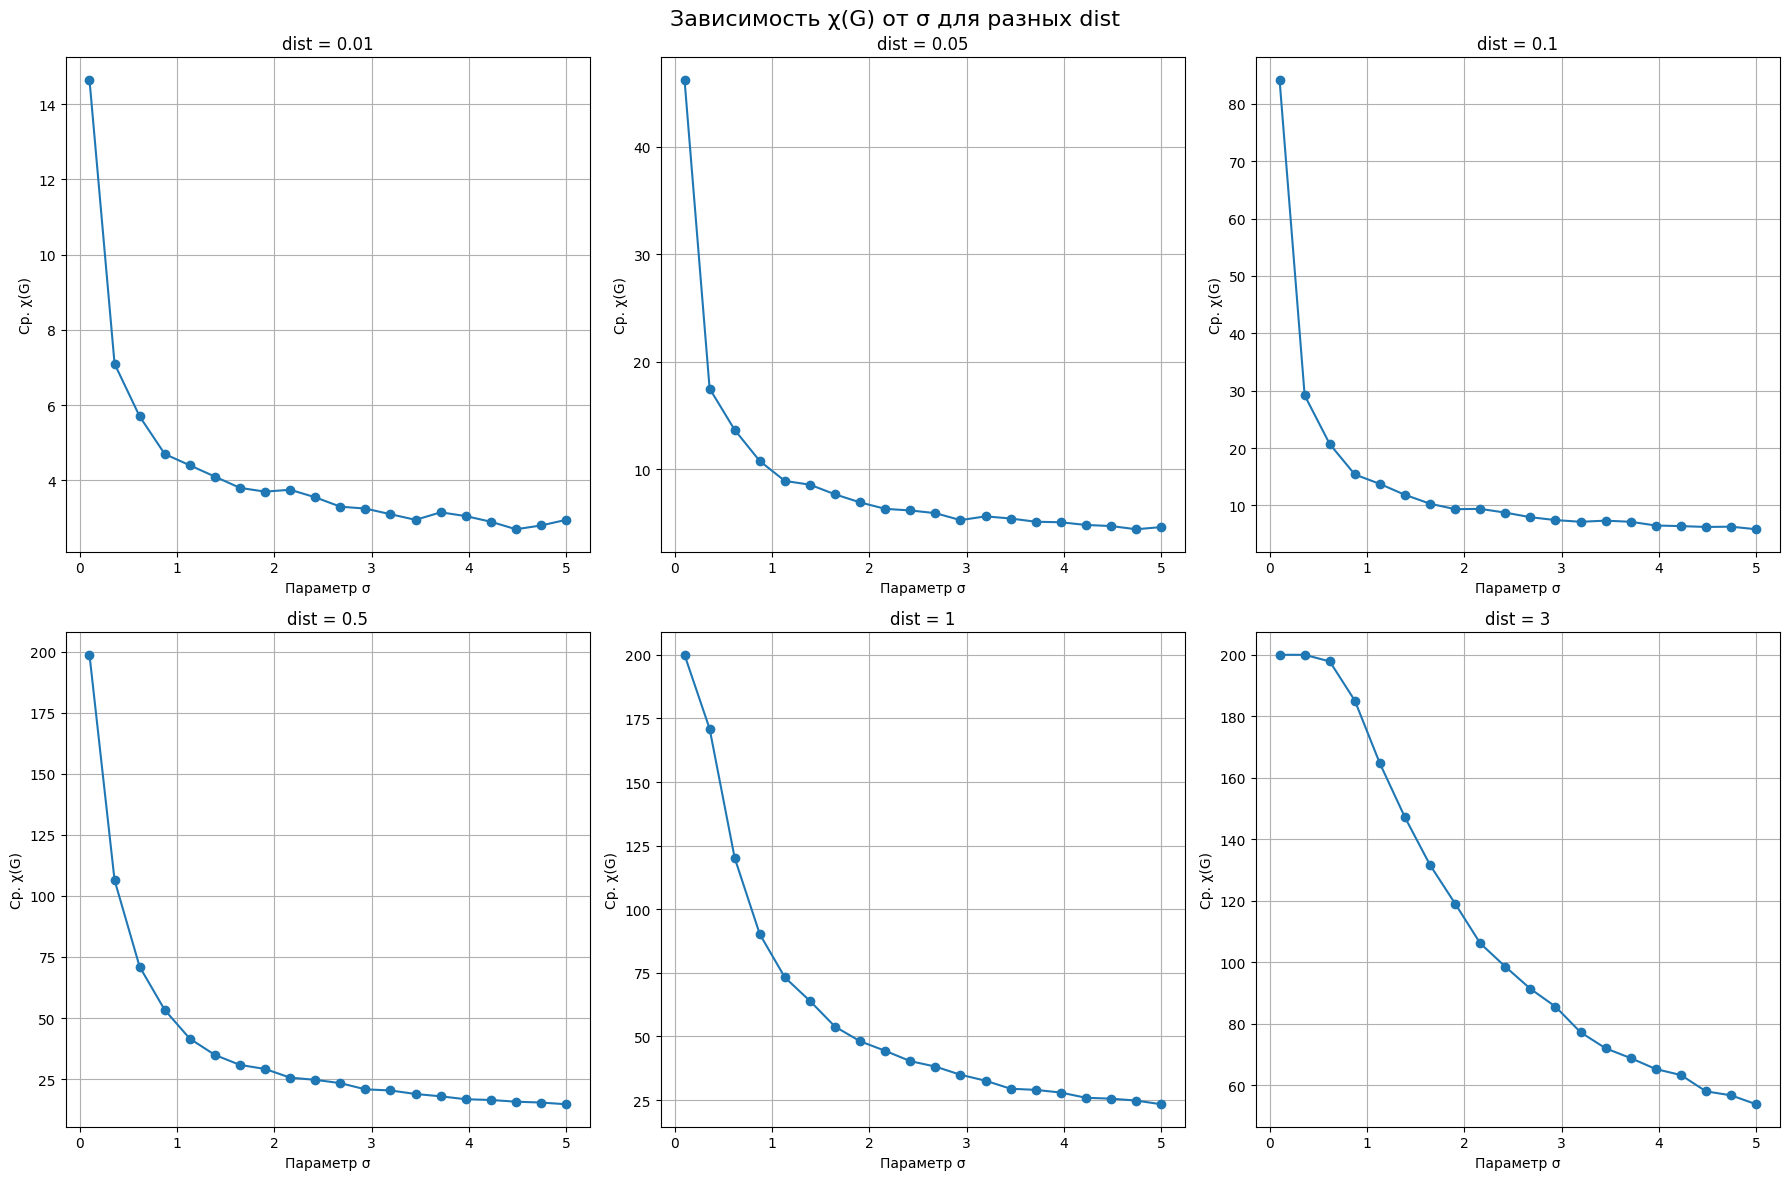

In [ ]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.5, 1, 3],
    'scale': np.linspace(0.1, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость χ(G) от σ для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for scale in param_grid['scale']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n,scale=scale)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['scale'], chromatic_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. χ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()


Эксперементы с графом dist и Student-t(ν).

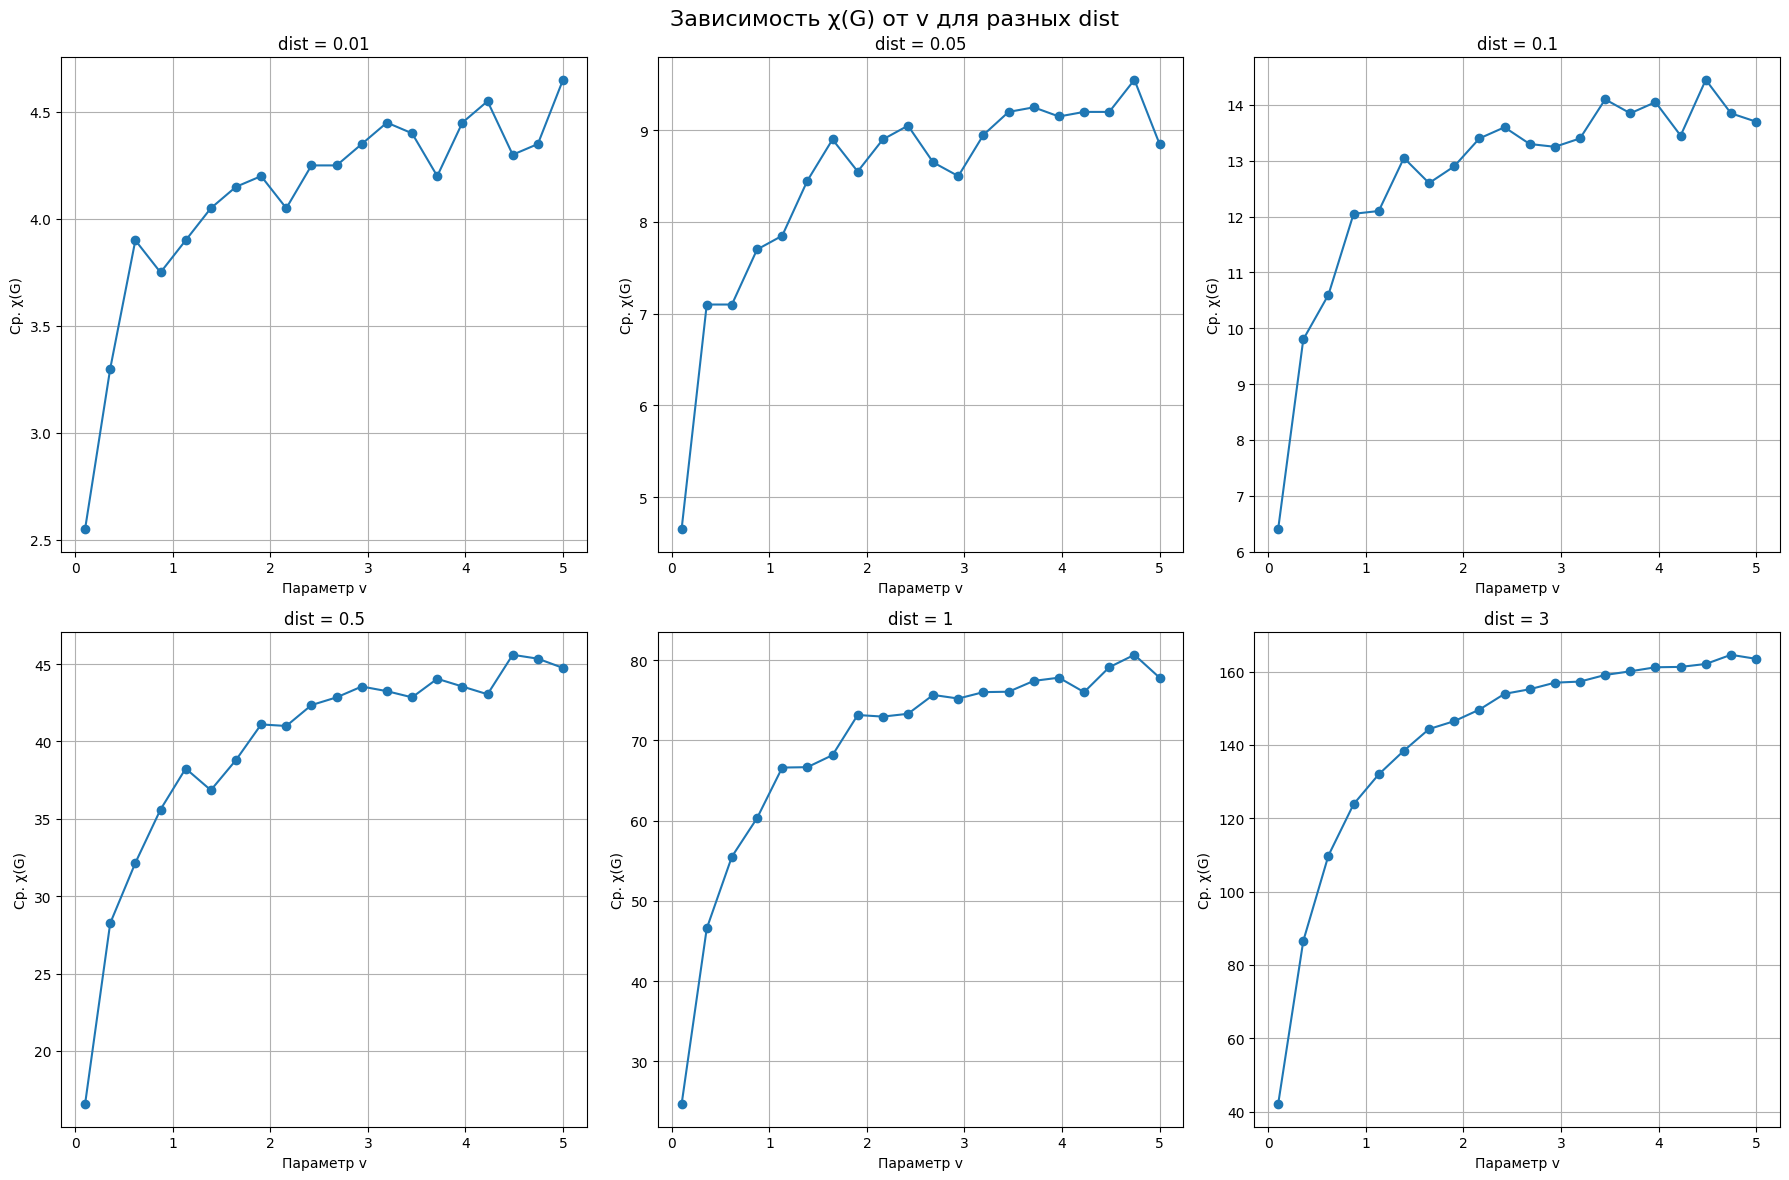

In [ ]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.5, 1, 3],
    'v': np.linspace(0.1, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость χ(G) от v для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for v in param_grid['v']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n,df=v)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['v'], chromatic_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. χ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()


Характеристика χ(G) на дистанционном графе показывает разные результаты для разных выборок. Для нормального распределения с ростом параметра σ хроматическое число убывает, а для распределения Student-t(ν) с ростом параметра v хроматическое число наооборот растет. Эта комбинация (χ(G) на дистанционном графе) может подойти для определения истинности гипотез.

**Исследование того, как ведет себя числовая характеристика T в зависимости
от параметров процедуры построения графа и размера выборки при
фиксированных значениях $θ = θ_0$ и $υ = υ_0$**

Эксперементы с графом knn.

Processing k_neighbors: 100%|██████████| 6/6 [19:31<00:00, 195.31s/it]


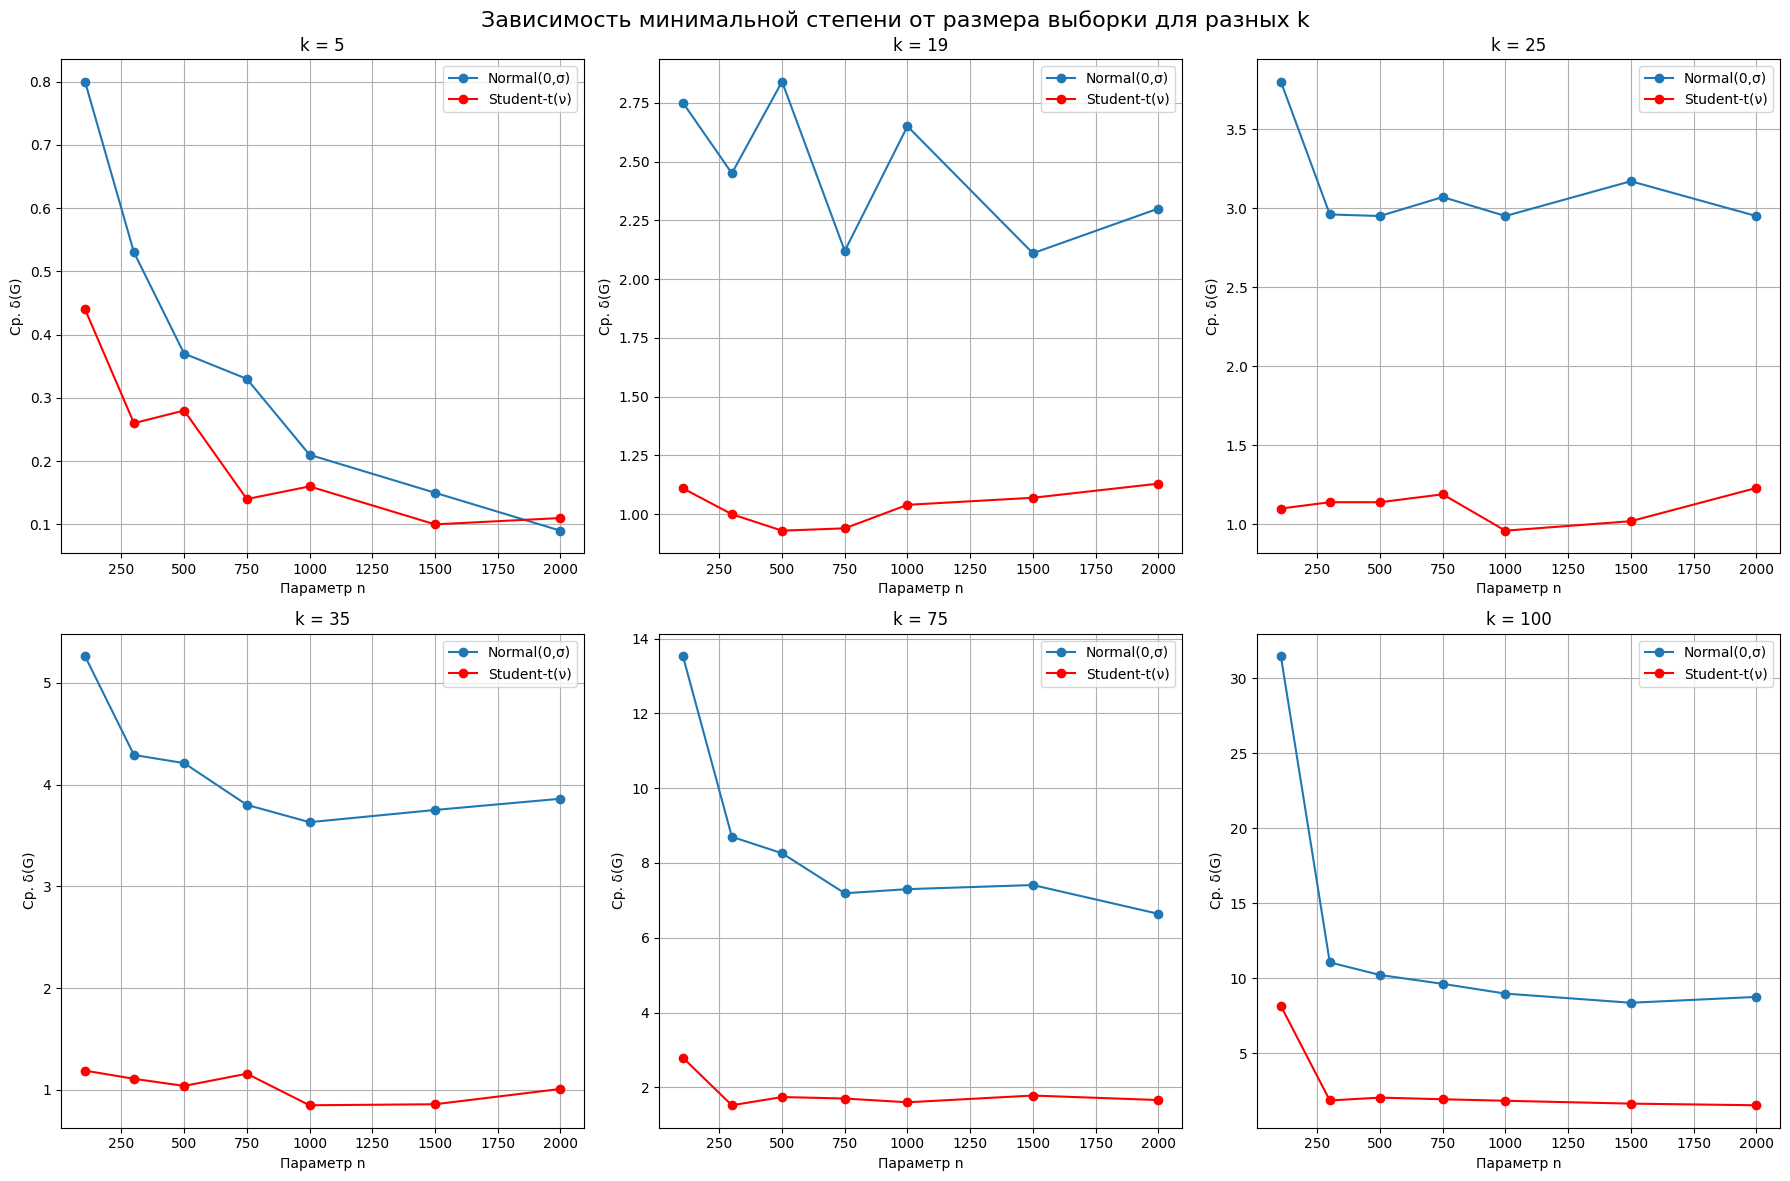

In [ ]:
param_grid = {
    'k_neighbors': [5, 19, 25, 35, 50, 75, 100],
    'n': [105, 300, 500, 750, 1000, 1500, 2000]
}
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от размера выборки для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for n in param_grid['n']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], min_degrees_means, marker='o', label='Normal(0,σ)')
    min_degrees_means = []
    for n in param_grid['n']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax.plot(param_grid['n'], min_degrees_means, marker='o', color='red', label='Student-t(ν)')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. δ(G)')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что график для Normal выше, чем график для Student. Это может помоч в проверке истинности $H_0$ и $H_1$.

Эксперементы с графом dist.

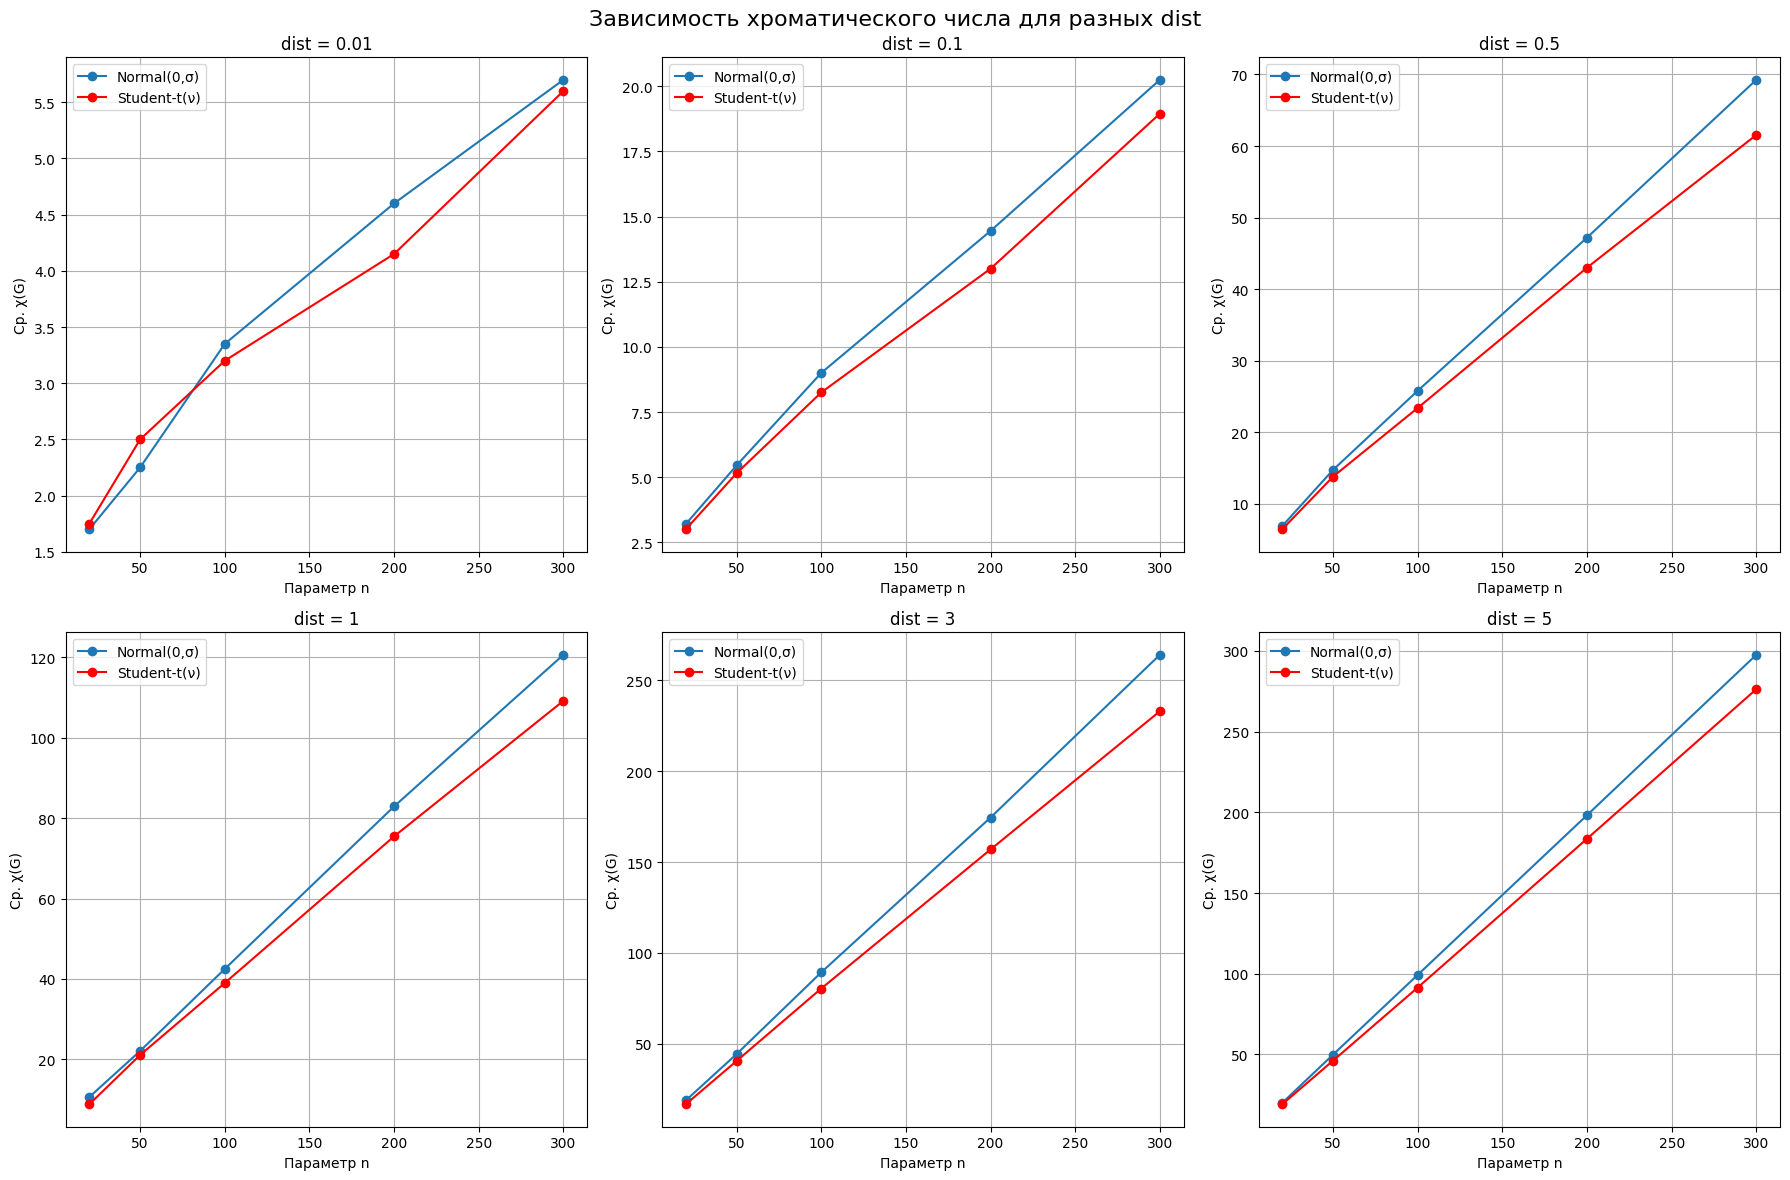

In [ ]:
param_grid = {
    'dist': [0.01, 0.1, 0.5, 1, 3, 5],
    'n': [20, 50, 100, 200, 300]
}
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость хроматического числа для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for n in param_grid['n']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], chromatic_means, marker='o', label='Normal(0,σ)')
    chromatic_means = []
    for n in param_grid['n']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax.plot(param_grid['n'], chromatic_means, marker='o', color='red', label='Student-t(ν)')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. χ(G)')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


К сожалению данные графики не сильно отличаются, в среднем график для Student-t(ν) ниже чем график для нормального распределения.

**Построить множество A в предположении $θ = θ_0$ и $υ = υ_0$ при мак-
симальной допустимой вероятности ошибки первого рода α = 0.055.
Оценим мощность полученного критерия.**

Начнем с dist графом и характеристикой χ(G).

Воспользуемся свойством: в любом дистанционном графе χ(G) = ω(G) почти наверное.
И будем считать кликовое число для нашей выборки. Превратим каждое число выборки в отрезок: $\xi-> [\xi-d/2, \xi+d/2]$, после этого найдем точку, в которой пересекается наибольшее число отрезков. Это и будет кликовое(храмотическое) число графа.
Для этого отсортируем отрезки по левой границе и за линейное время пройдемся по всем отрезкам.

In [12]:
def fast_chromatic_number(samples, d):
  events=[]
  for xi in samples:
    events.append((xi-d/2, 'start'))
    events.append((xi+d/2, 'end'))
  events.sort(key=lambda x: (x[0], x[1] == 'start'))
  max_count = 0
  active_segments = 0

  for x, typ in events:
      if typ == 'start':
          active_segments += 1
          if active_segments > max_count:
              max_count = active_segments
      else:
          active_segments -= 1

  return max_count

In [11]:
def generate_values_chi(n=500, n_trials=1000, d=1):
  T_H0=[]
  T_H1=[]
  for _ in range(n_trials):
    samples_1 = generate_normal_samles(n)
    samples_2 = generate_standard_t_samles(n)
    chromatic_1 = fast_chromatic_number(samples_1, d)
    chromatic_2 = fast_chromatic_number(samples_2, d)
    T_H0.append(chromatic_1)
    T_H1.append(chromatic_2)
  return T_H0, T_H1

In [14]:
from tqdm import tqdm
np.random.seed(42)
n_trials = 1000 # Количество испытаний.
alpha = 0.055 # Максимальная допустимая ошибка первого рода.
n = 500 # Размер выборки, для которой мы хотим определять ккакому распределению она относится.
T_H0=[]# Значения нашей характеристики для нормального распределения
T_H1=[]# Значения нашей характеристики для Student-t(ν)
T_H0, T_H1 = generate_values_chi(n, n_trials)

In [15]:
def frequencies(T_H0, T_H1):
  P=[]
  for value in list(set(T_H0) | set(T_H1)):
    P.append([value, T_H0.count(value)/len(T_H0), T_H1.count(value)/len(T_H1)])
  return P

def sort_key(triple):
    _, b, c = triple
    if b == 0:
        return (float('-inf'),)
    return (-(c / b),)

def greedy(T_H0, T_H1, alpha=0.055):
  P = frequencies(T_H0, T_H1) #Массив частот значений(условно вероятностей)
  P.sort(key=sort_key)# Сортируем элементы по убыванию P(H_1)/P(H_0).
  #Теперь построим множество А. Но для удобства будем строить его дополнение.
  A=[]
  current_error = 0
  power = 0
  for value, p0, p1 in P:
    if current_error + p0< alpha:
      current_error+=p0
      power+=p1
      A.append(value)
    else:
      break
  A= (set(T_H0) | set(T_H1)).difference(set(A))
  return A, current_error, power

In [ ]:
A, current_error, power = greedy(T_H0, T_H1, 0.055)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 229, 231, 234, 237, 238}
Ошибка первого рода: 0.045
Мощность: 0.594


Мы получили следующий результат: мощность полученного китерия 0.594, хороший ли это результат мне сложно сказать.

Теперь попробуем использовать KNN граф и характеристику δ(G).

In [ ]:
n_trials = 1000 # Количество испытаний.
alpha = 0.055 # Максимальная допустимая ошибка первого рода.
n = 500 # Размер выборки, для которой мы хотим определять ккакому распределению она относится.
T_H0=[]# Значения нашей характеристики для нормального распределения
T_H1=[]# Значения нашей характеристики для Student-t(ν)
np.random.seed(42)
for _ in tqdm(range(n_trials), desc="Испытаний"):
  samples_1 = generate_normal_samles(n)
  G = generate_knn_digraph(samples_1, 100)
  delta_1 = min_node_degree(G)
  T_H0.append(delta_1)
  samples_2 = generate_standard_t_samles(n)
  G = generate_knn_digraph(samples_2, 100)
  delta_2 = min_node_degree(G)
  T_H1.append(delta_2)


Испытаний: 100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]


In [ ]:
A, current_error, power = greedy(T_H0, T_H1, 0.055)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
Ошибка первого рода: 0.035
Мощность: 0.717


Характеристика $in\_\delta(G)$ на графе KNN показывает лучшее результаты. При ошибке первого рода 0.035 мощность полученного критеия равна 0.717.

**Исследование важности характеристик, как признаков классификации.
Изучить меняется ли важность характеристик с ростом n.**

Добавим функцию для подсчета минимальной степени дистанционного графа.

In [8]:
#O(n^2) - для каждой вершины находим все связанные с ней.
def fast_minimum_degree_number(samples, d=1):
  events=[]
  for xi in samples:
    events.append([xi-d/2,xi+d/2])
  events.sort(key=lambda x: (x[0]))
  degrees = [0]*len(samples)
  for i in range(len(samples)):
    for j in range(i+1, len(samples)):
      if events[i][1]>events[j][0]:
        degrees[i]+=1
        degrees[j]+=1
      else:
        break
  return np.min(degrees)

Добавим функцию для генерации значений для минимальной степени.

In [7]:
def generate_values_min_degrees(n=500, n_trials=1000, d=1):
  T_H0=[]
  T_H1=[]
  for _ in range(n_trials):
    samples_1 = generate_normal_samles(n)
    samples_2 = generate_standard_t_samles(n)
    min_degree_1 = fast_minimum_degree_number(samples_1, d)
    min_degree_2 = fast_minimum_degree_number(samples_2, d)
    T_H0.append(min_degree_1)
    T_H1.append(min_degree_2)
  return T_H0, T_H1

В качесве модели я выбрал dist граф. Если я правильно понял, мне(Виктор) надо проанализировать две характеристики: $\delta(G)$ and $\chi(G)$ на dist graphs.

Processing sample size: 100%|██████████| 12/12 [03:32<00:00, 17.69s/it]


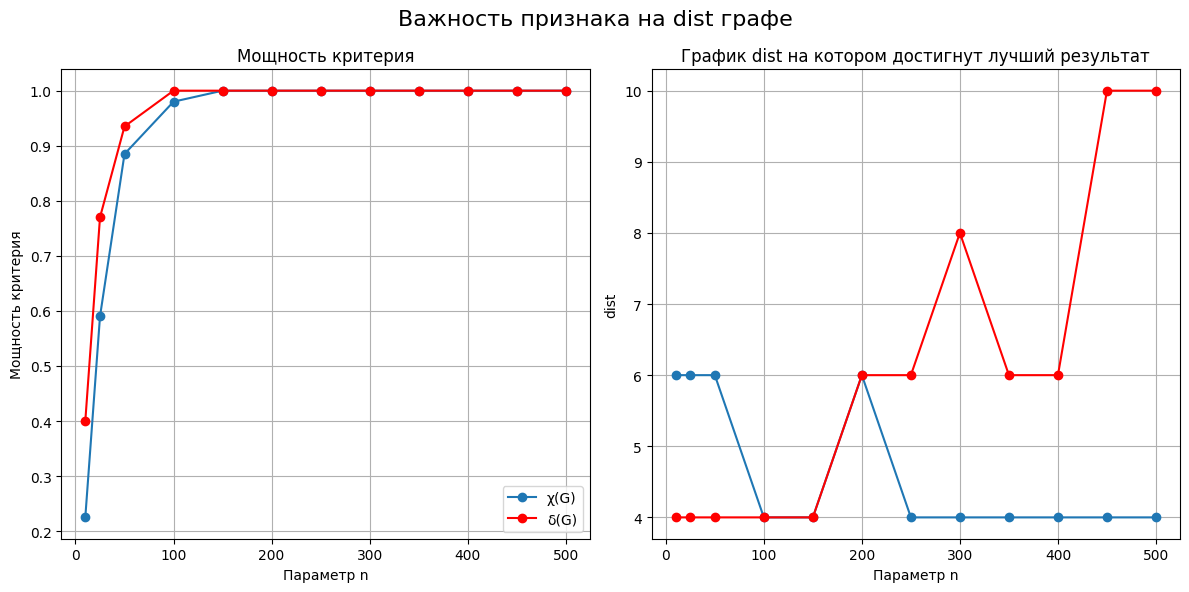

In [ ]:
param_grid = {
    'n': [10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'd': [1, 2, 4, 6, 8, 10, 12]
}
np.random.seed(42)
powers_chi = []
dists_chi = []
powers_min_degrees = []
dists_min_degrees = []
for n in tqdm(param_grid['n'], desc='Processing sample size'):
  #Chi
  best_power = -1
  best_dist = -1
  for d in param_grid['d']:
    T_H0, T_H1 = generate_values_chi(n, 200, d)
    A, current_error, power = greedy(T_H0, T_H1, 0.055)
    if power>best_power:
      best_power=power
      best_dist = d
  powers_chi.append(best_power)
  dists_chi.append(best_dist)
  #min degrees
  best_power = -1
  best_dist = -1
  for d in param_grid['d']:
    T_H0, T_H1 = generate_values_min_degrees(n, 200, d)
    A, current_error, power = greedy(T_H0, T_H1, 0.055)
    if power>best_power:
      best_power=power
      best_dist = d
  powers_min_degrees.append(best_power)
  dists_min_degrees.append(best_dist)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Важность признака на dist графе', fontsize=16)


ax = axes[0]
ax.plot(param_grid['n'], powers_chi, marker='o', label='χ(G)')
ax.plot(param_grid['n'], powers_min_degrees, marker='o', color='red', label='δ(G)')
ax.set_title(f'Мощность критерия')
ax.set_xlabel('Параметр n')
ax.set_ylabel('Мощность критерия')
ax.legend()
ax.grid(True)

ax = axes[1]
ax.plot(param_grid['n'], dists_chi, marker='o', label='χ(G)')
ax.plot(param_grid['n'], dists_min_degrees, marker='o', color='red', label='δ(G)')
ax.set_title(f'График dist на котором достигнут лучший результат')
ax.set_xlabel('Параметр n')
ax.set_ylabel('dist')
ax.grid(True)

plt.tight_layout()
plt.show()


Я получил следующие результаты: при размере выборки больше 100 мощность признаков равна 1. Это свидетельствует о том, что множества значений характеристик, которые получаются на графах, построенных на разных последовательностях, не пересекаются.

In [76]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class Classifier():
    def __init__(self, alpha=0.055):
        self.alpha = alpha
        self.A0 = []
        self.A1 = []

    def fit(self, X_train, y_train):
        T_H0 = list(X_train['min_degrees'][y_train == 1])
        T_H1 = list(X_train['min_degrees'][y_train == 0])
        self.A0, _, _ = greedy(T_H0, T_H1, self.alpha)


        T_H0 = list(X_train['chi'][y_train == 1])
        T_H1 = list(X_train['chi'][y_train == 0])
        self.A1, _, _ = greedy(T_H0, T_H1, self.alpha)

    def predict(self, X_test):
        y_pred = []
        for _, row in X_test.iterrows():
            if row['min_degrees'] in self.A0 and row['chi'] in self.A1:
                y_pred.append(1)
            elif row['min_degrees'] in self.A0 or row['chi'] in self.A1:
              y_pred.append(random.choice([1, 0]))
            else:
              y_pred.append(0)

        return y_pred

Начнем с LogisticRegression.

In [20]:
import pandas as pd
from tqdm import tqdm
#Сгенерируем датасетик. Для каждого размера выборки n сгенерируем по 10000 примеров(5000 на Normal и 5000 на Student)
data = {}
n_samples = [10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500]
for n in tqdm(n_samples):
  min_degrees = []
  chis = []
  classes = []
  for _ in range(5000):
    sample_N = generate_normal_samles(n)
    sample_Student = generate_standard_t_samles(n)
    sample_N_min_degree = fast_minimum_degree_number(sample_N, d=4)
    sample_Student_min_degree = fast_minimum_degree_number(sample_Student, d=4)
    sample_N_chi = fast_chromatic_number(sample_N, d=6)
    sample_Student_chi = fast_chromatic_number(sample_Student, d=6)
    min_degrees.append(sample_N_min_degree)
    min_degrees.append(sample_Student_min_degree)
    chis.append(sample_N_chi)
    chis.append(sample_Student_chi)
    classes.append(1)
    classes.append(0)
  df = pd.DataFrame({
    'min_degrees': min_degrees,
    'chi': chis,
    'class': classes
  })
  data[n] = df



100%|██████████| 13/13 [14:21<00:00, 66.24s/it] 


In [77]:
from sklearn.utils import resample

def bootstrap_metrics(X_test, y_test, classifier, B=100):
    metrics = {'Accuracy': [], 'Recall': [], 'Precision': [], 'F1': []}
    for _ in range(B):
        X_bs, y_bs = resample(X_test, y_test, replace=True)
        y_pred = classifier.predict(X_bs)
        metrics['Accuracy'].append(accuracy_score(y_bs, y_pred))
        metrics['Recall'].append(recall_score(y_bs, y_pred))
        metrics['Precision'].append(precision_score(y_bs, y_pred))
        metrics['F1'].append(f1_score(y_bs, y_pred))

    return metrics
    for name, values in metrics.items():
        print(f"{name}: mean = {np.mean(values):.3f}, std = {np.std(values):.3f}")

In [78]:
metrics_lr = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_lr_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_rf = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_rf_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_my = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_my_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

for n in tqdm(n_samples):
  X_train, X_test, y_train, y_test = train_test_split(
    data[n][['min_degrees', 'chi']], data[n]['class'], test_size=0.3, random_state=42
  )
  model = LogisticRegression(max_iter=1000, penalty='l2')
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_lr[name].append(np.round(np.mean(values), 4))
        metrics_lr_d[name].append(np.round(np.std(values), 4))

  model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    max_features=2,
    min_samples_split=2,
    random_state=42
  )
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_rf[name].append(np.round(np.mean(values), 4))
        metrics_rf_d[name].append(np.round(np.std(values), 4))

  model = Classifier()
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_my[name].append(np.round(np.mean(values), 4))
        metrics_my_d[name].append(np.round(np.std(values), 4))



100%|██████████| 13/13 [03:18<00:00, 15.30s/it]


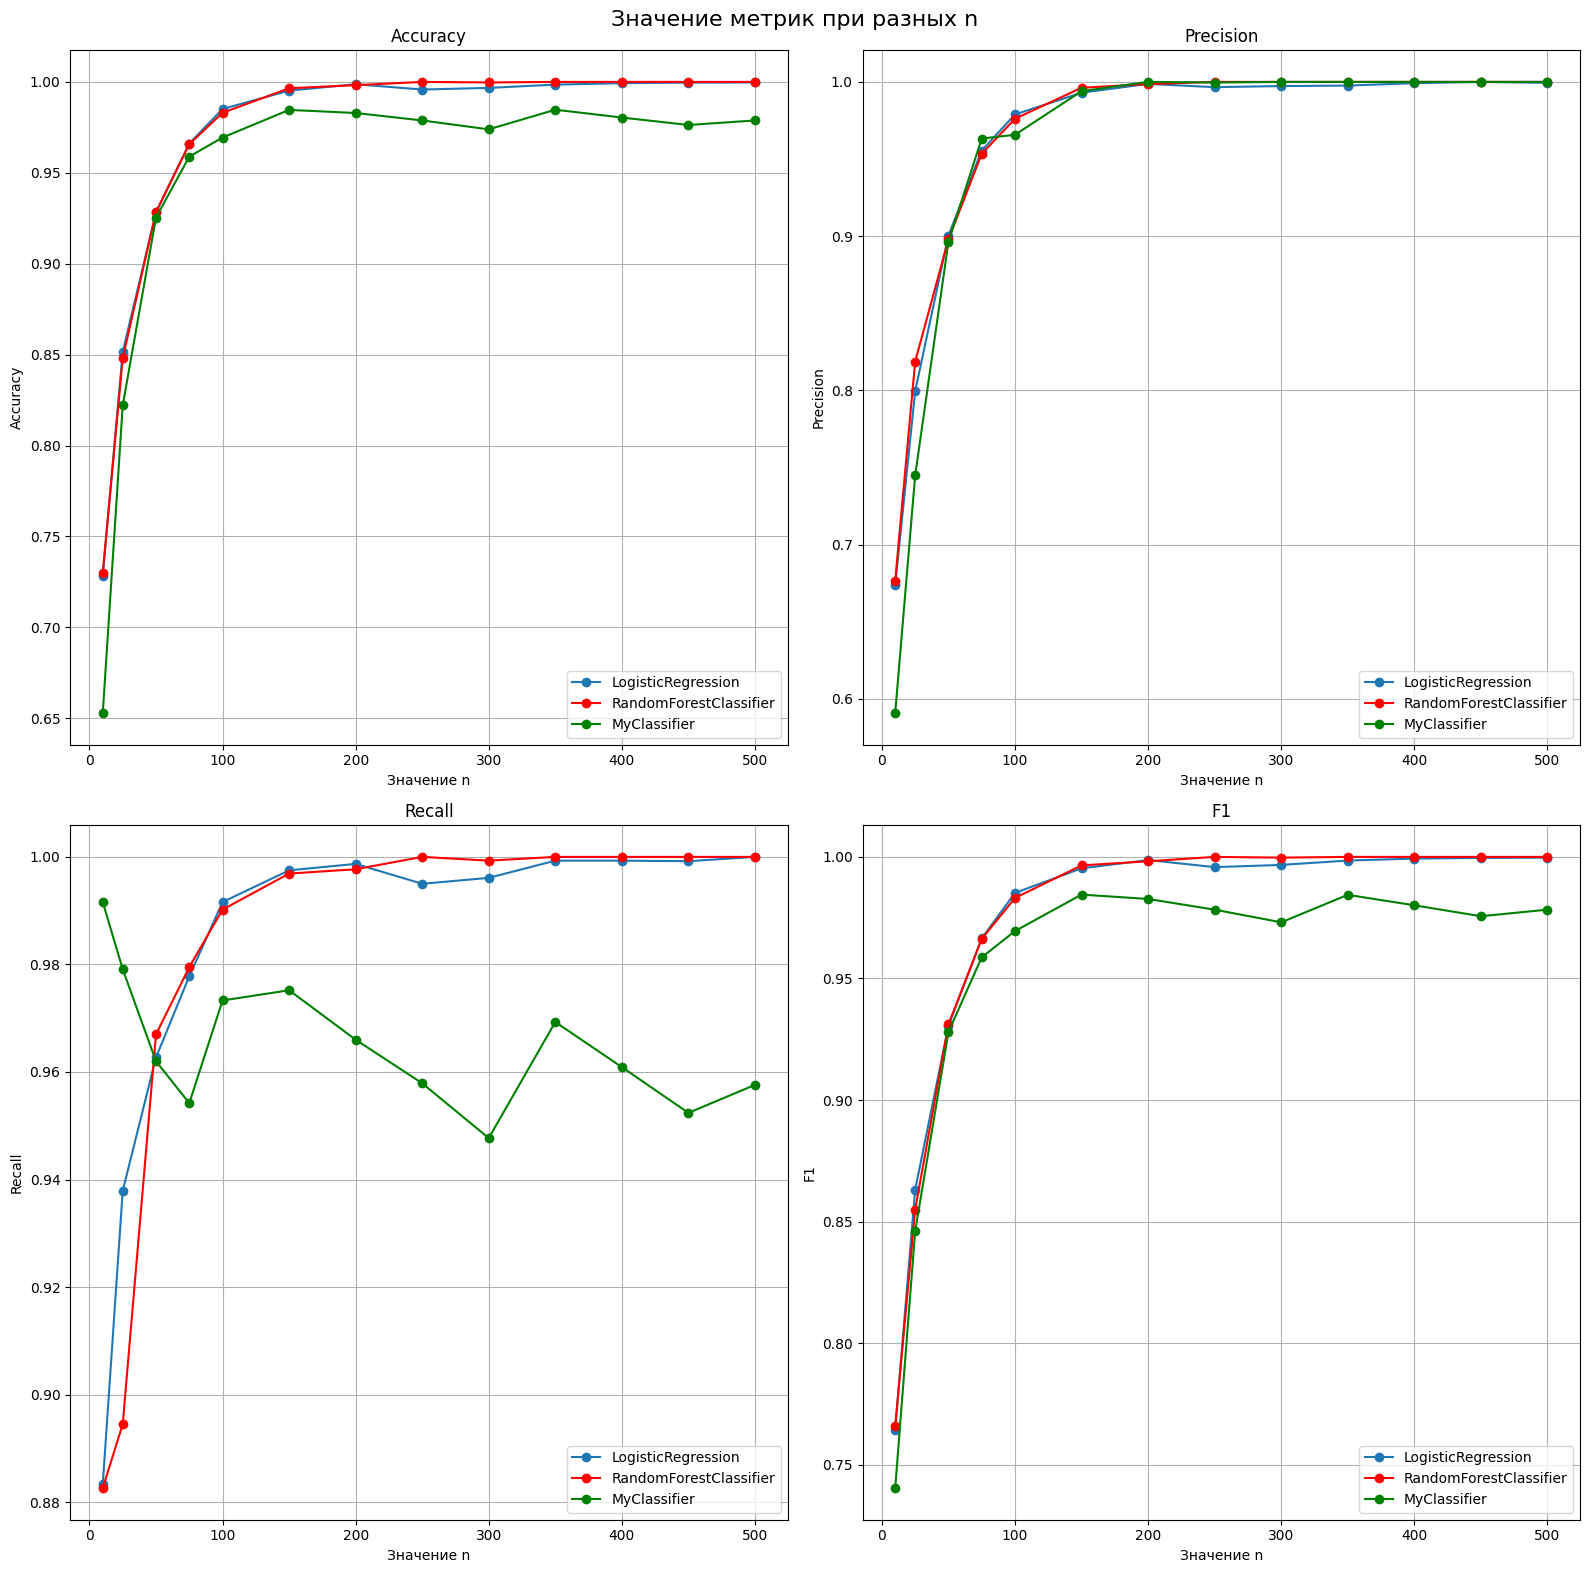

In [79]:
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
  fig.suptitle('Значение метрик при разных n', fontsize=16)

  ax = axes[0, 0]
  ax.plot(n_samples, metrics_lr['Accuracy'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Accuracy'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Accuracy'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Accuracy')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Accuracy')
  ax.legend()
  ax.grid(True)

  ax = axes[0, 1]
  ax.plot(n_samples, metrics_lr['Precision'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Precision'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Precision'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Precision')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Precision')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 0]
  ax.plot(n_samples, metrics_lr['Recall'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Recall'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Recall'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Recall')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Recall')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 1]
  ax.plot(n_samples, metrics_lr['F1'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['F1'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['F1'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'F1')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('F1')
  ax.legend()
  ax.grid(True)


  plt.tight_layout()
  plt.show()

Как мы видем, используя обе характеристики мы получаем точность 95% уже при n=75. Я думаю, что это хороший результат. Стоит отметить, что мой классификатор не очень хорошую( относительно других классификаторов) метрику recall, это вызвано его реализацией: в случае, когда характиристики указывают на разные гипотизы я выбираюю ответ равновероятно, это и дает данную погрешность. В остальных метриках классификаторы ведут себя схоже: RandomForestClassifier чуть лучше, LogisticRegression чуть хуже, MyClassifier еще чуть хуже.  

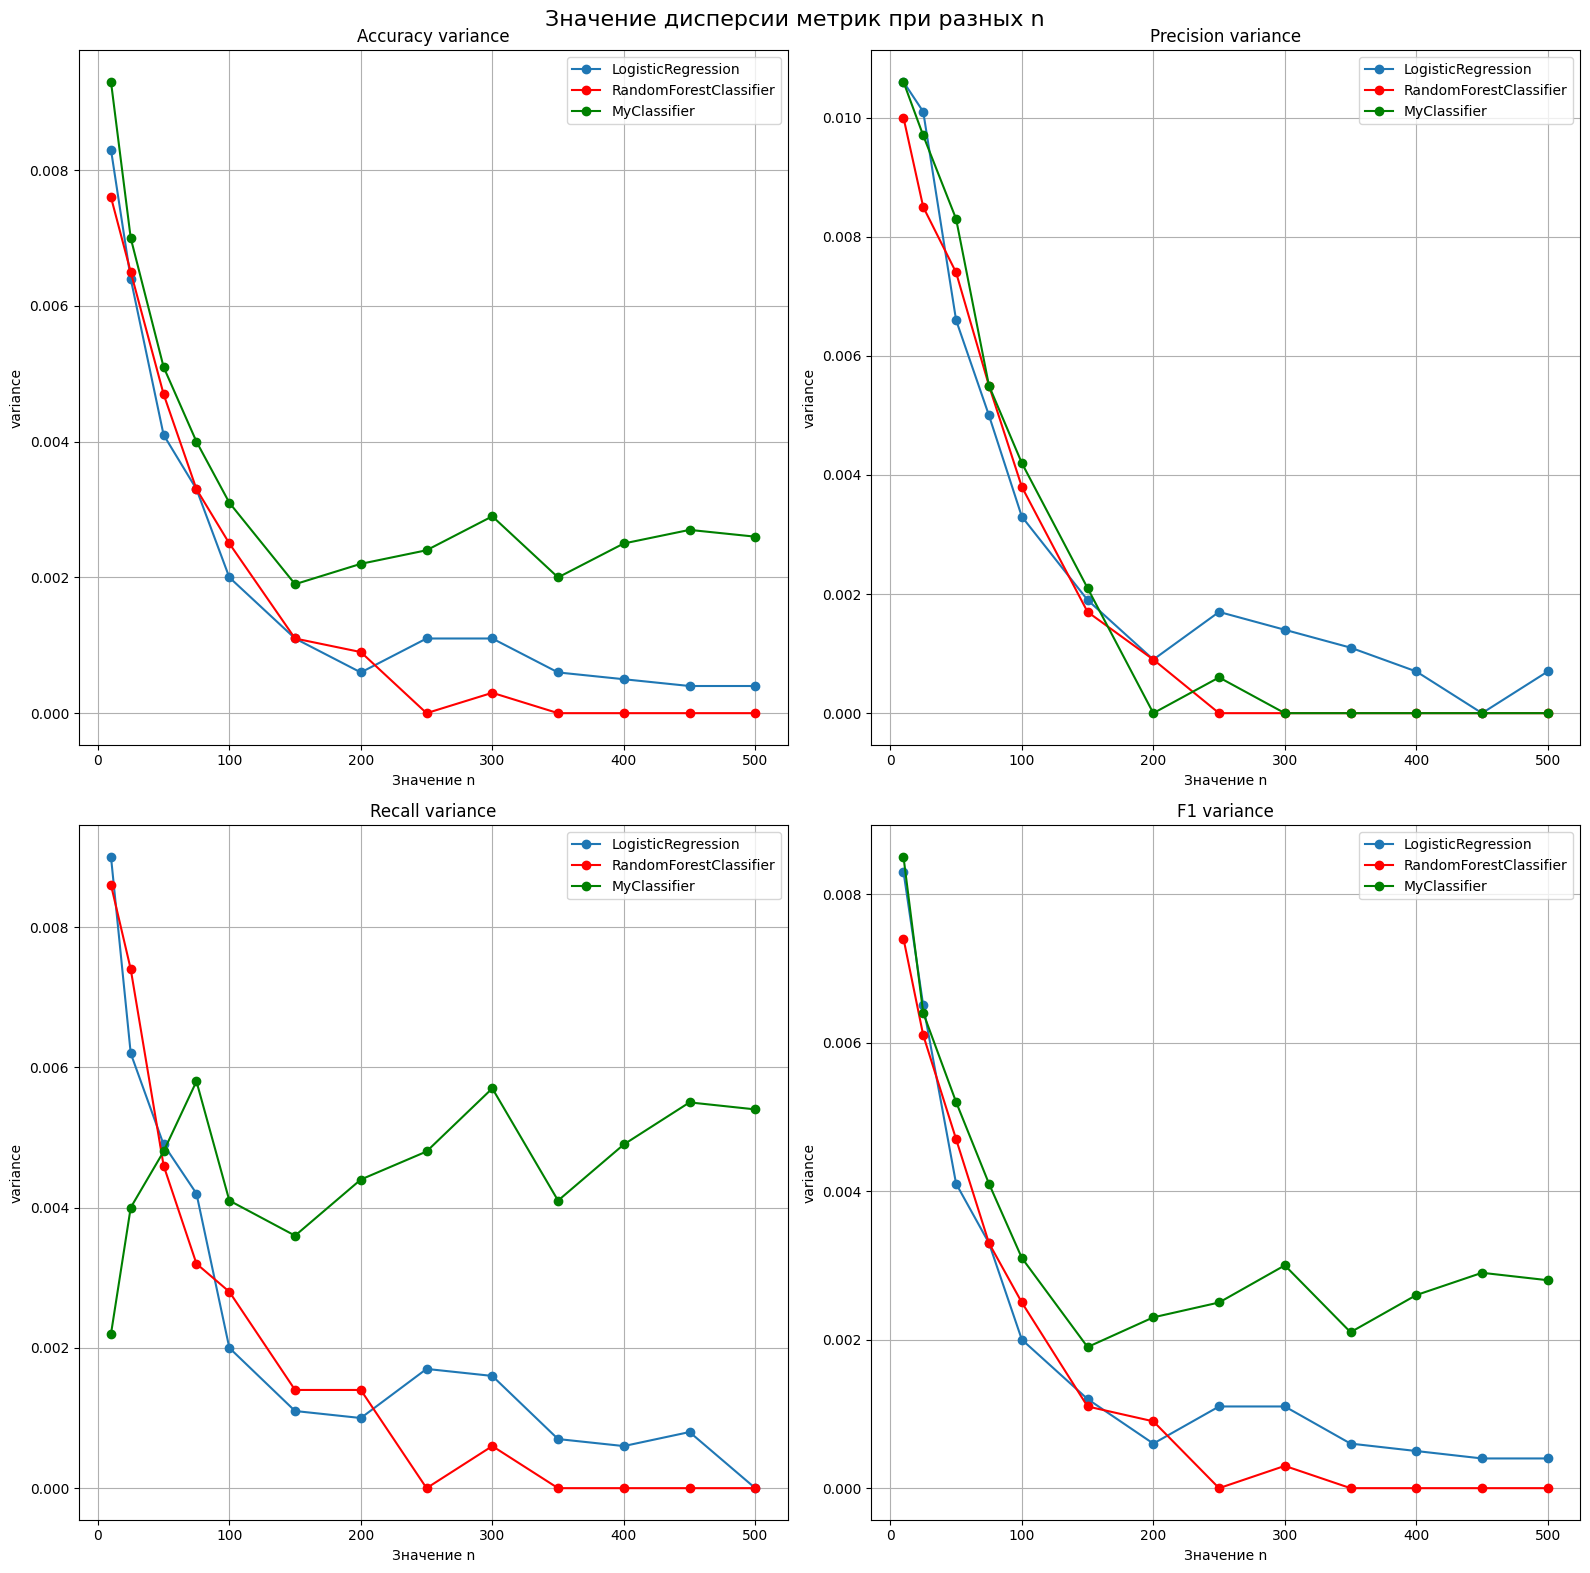

In [80]:
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
  fig.suptitle('Значение дисперсии метрик при разных n', fontsize=16)

  ax = axes[0, 0]
  ax.plot(n_samples, metrics_lr_d['Accuracy'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Accuracy'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Accuracy'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Accuracy variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[0, 1]
  ax.plot(n_samples, metrics_lr_d['Precision'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Precision'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Precision'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Precision variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 0]
  ax.plot(n_samples, metrics_lr_d['Recall'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Recall'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Recall'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Recall variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 1]
  ax.plot(n_samples, metrics_lr_d['F1'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['F1'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['F1'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'F1 variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)


  plt.tight_layout()
  plt.show()

Посмотрим на десперсию метрик, для всех метрик и классификаторов верно, что коэффициент вариации находится в диапазоне от 10% до 0% и уменьшается с ростом n (исключение метрика recall и MyClassifier, но причину этого я уже описывал выше). Хороший ли это показатель, зависит от задачи.

In [83]:
#Теперь займемся оценкой ошибки первого рода и мощности критерия у MyClassifier
FPRs = []
Powers = []
for n in tqdm(n_samples):
  X_train, X_test, y_train, y_test = train_test_split(
    data[n][['min_degrees', 'chi']], data[n]['class'], test_size=0.3, random_state=42
  )
  model = Classifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  fpr = 0
  count = 0
  for a, b in zip(y_pred, y_test):
    if a == 0 and b == 1:
        fpr += 1
    if b == 1:
      count+=1
  fpr = fpr/count
  power = 0
  count = 0
  for a, b in zip(y_pred, y_test):
    if a == 0 and b == 0:
        power += 1
    if b == 0:
      count+=1
  power = power/count
  FPRs.append(fpr)
  Powers.append(power)


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


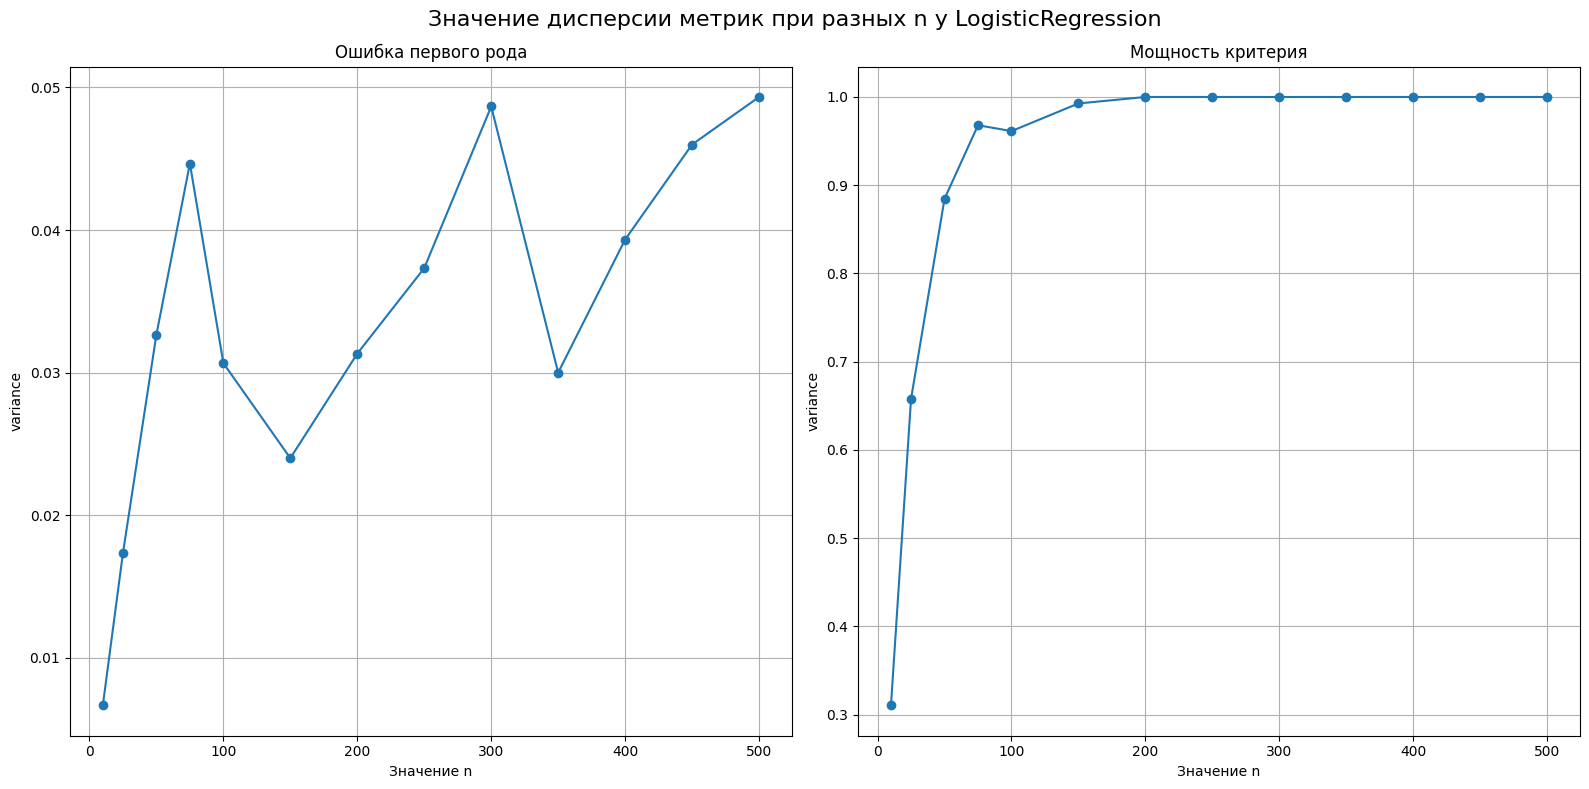

In [85]:
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  fig.suptitle('Значение дисперсии метрик при разных n у LogisticRegression', fontsize=16)

  ax = axes[0]
  ax.plot(n_samples, FPRs, marker='o')
  ax.set_title(f'Ошибка первого рода')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.grid(True)

  ax = axes[1]
  ax.plot(n_samples, Powers, marker='o')
  ax.set_title(f'Мощность критерия')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.grid(True)



  plt.tight_layout()
  plt.show()

Можно заметить, что с ростом n мощность критерия растет, при 200 она уже равна 1. При этом ошибка первого рода держится в диапазоне, который задан при создании классификатора(0.055). Можно заметить, что при очень маленьких n, ошибка очень маленькая, это просто значит, что нам пришлось почти все возможные значения закинуть в множество А, а поскольку значений мало, шаг большой. Если оценить результат в общем, то при n = 50 мы получаем вероятность в районе 90%, я думаю, что это хороший результат.